In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns

from optbinning import OptimalBinning

In [2]:
df = pd.read_csv("credit_data.csv").dropna().drop_duplicates()

In [3]:
# Step 0: Dividir amostra entre aprovados e rejeitados para a simulação
X_aprovados, X_rejeitados, y_aprovados, y_rejeitados = train_test_split(
    df.drop(columns=['default', 'clientid']), df['default'], test_size=0.3, random_state=42
)

In [4]:
# Step 1: Construir modelo na população conhecida (KGB)
scorecard_A = LogisticRegression()
scorecard_A.fit(X_aprovados, y_aprovados)

LogisticRegression()

In [5]:
# Step 1.1: Criar faixas de risco (com optimal binning)
prob_bom_aprovados = scorecard_A.predict_proba(X_aprovados)[:, 0]
X_aprovados['prob_0_ScA'] = prob_bom_aprovados

In [12]:
min_n_faixas = 5
max_n_faixas = 20

In [13]:
X = X_aprovados['prob_0_ScA'].values
y = y_aprovados.values
optbin = OptimalBinning(name='pred_prob', dtype='numerical', solver='cp',
                        min_n_bins=min_n_faixas,
                        max_n_bins=max_n_faixas, 
                        # min_prebin_size=0.05,
                        # max_bin_size=0.10,
                        # min_event_rate_diff=0.015,
                        min_bin_size=0.05
                        )

optbin.fit(X, y)
print(optbin.status)

OPTIMAL


In [15]:
binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.38)",90,0.064378,12,78,0.866667,-3.764815,1.567492,0.127556
1,"[0.38, 0.76)",123,0.087983,55,68,0.552846,-2.105188,0.686959,0.072862
2,"[0.76, 0.85)",74,0.052933,56,18,0.243243,-0.758033,0.039622,0.004838
3,"[0.85, 0.91)",70,0.050072,56,14,0.200000,-0.506719,0.015410,0.001906
4,"[0.91, inf)",1041,0.744635,1036,5,0.004803,3.440671,2.839767,0.244102
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1398,1.000000,1215,183,0.130901,,5.149251,0.451264


In [16]:
bins = optbin.splits
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, len(bins), 1)
labels = [i for i in range(1, (len(bins)))]

In [17]:
X_aprovados['faixas_risco'] = pd.cut(X_aprovados.prob_0_ScA, bins=bins, labels=labels)

In [18]:
bad_rate_por_faixa = pd.crosstab(X_aprovados.faixas_risco,
                                 y_aprovados,
                                 normalize='index').reset_index().rename(columns={1: 'Bad_Rate'})

In [19]:
bad_rate_por_faixa

default,faixas_risco,0,Bad_Rate
0,1,0.134831,0.865169
1,2,0.447154,0.552846
2,3,0.756757,0.243243
3,4,0.800000,0.200000
4,5,0.995197,0.004803


In [20]:
# Step 2: Estimar probabilidade de ser BOM nos rejeitados com o modelo feito baseado no KGB
prob_bom_rejeitados = scorecard_A.predict_proba(X_rejeitados)[:, 0]
X_rejeitados['prob_0_ScA'] = prob_bom_rejeitados

In [21]:
# Step 2.1: Encontrar a faixa de risco de acordo com o modelo KGB, com sua respetiva bad rate
X_rejeitados['faixas_risco'] = pd.cut(X_rejeitados.prob_0_ScA, bins=bins, labels=labels)
rejeitados = X_rejeitados.merge(bad_rate_por_faixa[['faixas_risco', 'Bad_Rate']], on='faixas_risco')

In [26]:
def parceling(row, fator_lambda):
    prob_scorecardA = fator_lambda * row['Bad_Rate']
    performances_simuladas = []
    # Gera número aleatório entre 0 e 1
    r = np.random.uniform(0, 1)

    if r < prob_scorecardA:
        row['default'] = int(1)
    else:
        row['default'] = int(0)

    return row

In [35]:
# Step 3: Gerar performance dos rejeitados usando parceling simples
fator = 1.5
rejeitados_inferidos = rejeitados.apply(parceling, args=(fator,), axis=1)

In [36]:
rejeitados_inferidos['default'] = rejeitados_inferidos['default'].astype(int)

In [37]:
pd.crosstab(rejeitados_inferidos.faixas_risco,
            rejeitados_inferidos.default,
            normalize='index').multiply(100).round(2).reset_index().rename(columns={1: 'Bad_Rate'})

default,faixas_risco,0,Bad_Rate
0,1.0,0.00,100.00
1,2.0,8.45,91.55
2,3.0,50.00,50.00
3,4.0,67.57,32.43
4,5.0,99.53,0.47


In [38]:
aprovados = pd.concat([X_aprovados, y_aprovados], axis=1)
rejeitados = rejeitados_inferidos[['income', 'age', 'loan', 'prob_0_ScA', 'faixas_risco', 'default']]

In [39]:
# Step 4: Modelar com KGB + inferidos
df_final = pd.concat([aprovados, rejeitados], axis=0)

In [40]:
# Step 4.1: Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    df_final[['income', 'age', 'loan']], df_final['default'], test_size=0.2, random_state=42
)

In [41]:
scorecard_B = LogisticRegression()
scorecard_B.fit(X_train, y_train)

LogisticRegression()

In [42]:
y_pred = scorecard_B.predict(X_test)

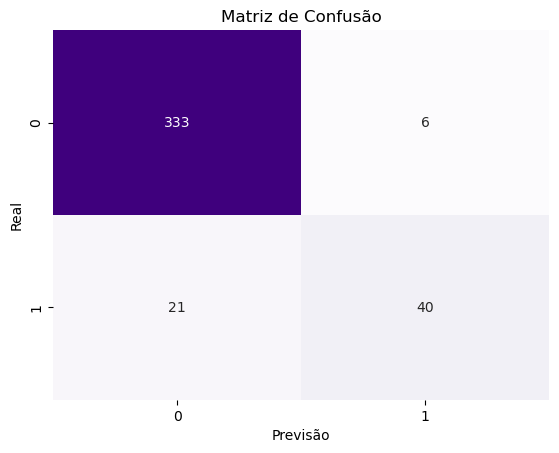

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       339
           1       0.87      0.66      0.75        61

    accuracy                           0.93       400
   macro avg       0.91      0.82      0.85       400
weighted avg       0.93      0.93      0.93       400



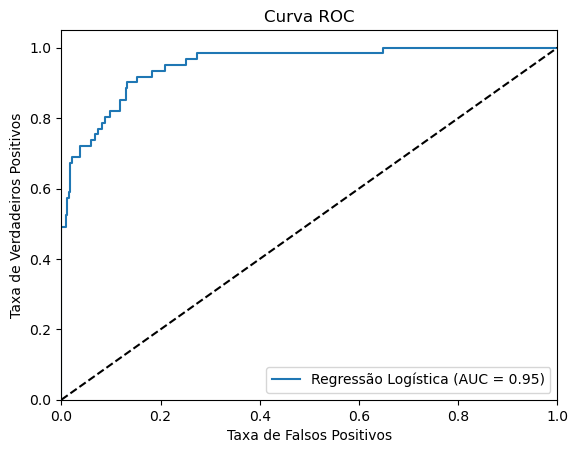

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, scorecard_B.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, scorecard_B.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label=f'Regressão Logística (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()